###**Pré-processamentos possiveis**:

- **Remoção de fundo**: Remover o fundo da imagem para reduzir a complexidade do aprendizado pelo modelo, dada a variabilidade de cores, contraste e iluminação entre as imagens;
- **Conversão para escala de cinza**: Como a cor não é uma informação relevante para detecção do gesto, as imagens serão convertidas para escala de cinza;
- **Realce e ajuste de iluminaçao**: aplicação de maior contraste nas cores da imagem para aprimorar o facilitar a detecção da posição dedos na frente da palma da mão. Além disso, diferentes imagens estao com diferentes níveis de iluminação. Dessa forma, corrigir as variaçoes de iluminação para dar destaque às mãos;
- **Suavização para redução de ruídos**: Aplicar filtros de suavizaçao para reduçao de ruídos afim de facilitar a detecçao das bordas;
- **Detecção de borda**: Detecção das bordas para mapear o formato exato da mão;
- **Normalização**: Normalizar os pixels da imagem;

###**Ações:**

- **Segmentação**: Há imagens em que o antebraço está completamente exposto, enquanto que há imagens em que o antebraço praticamente não aparece. Nesse caso, segmentar apenas a mão é importante;

###**Riscos:**

- Há imagens nas quais uma parte dos dedos são cortados, isso pode prejudicar a leitura da letra pelo modelo;
- O aparecimento do antebraço na imagem pode gerar confusões pelo modelo;

##Download dos dados

In [ ]:
pip install opendatasets --upgrade

In [ ]:
pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
from opendatasets import download

download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: matheusvieirabarros
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:27<00:00, 40.6MB/s]


## Configuração Inicial

Configuração e import de bibliotecas, além da definição da imagem de referência.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from rembg import remove
from tensorflow import keras, data

plt.rcParams['axes.grid'] = False  # Desativa as grades nos plots.

In [ ]:
image_path = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/S/S55.jpg'
imagem = cv2.imread(image_path)
image_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

## Primeiras Impressões das Imagens

Vamos plotar a imagem de referência para termos a primeira impressão, e a partir disso, realizar o pré-processamento.

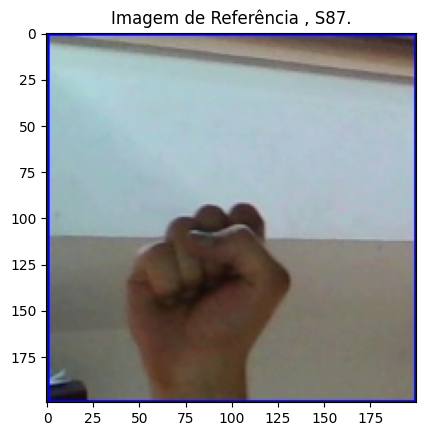

In [ ]:
plt.imshow(image_rgb)
plt.title("Imagem de Referência , S87.")
plt.show()

Vamos agora, explorar as propriedades da imagem, como suas dimensões e tipo de encoding.

In [ ]:
altura, largura, canais = imagem.shape

propriedades = [
    ('Altura:', altura),
    ('Largura:', largura),
    ('Canais de cor:', canais),
    ('Tipo de dado:', imagem.dtype),
    ('Desvio Padrão', imagem.std())
]

for propriedade, valor_propriedade in propriedades:
    print(f'{propriedade} {valor_propriedade}')


Altura: 200
Largura: 200
Canais de cor: 3
Tipo de dado: uint8
Desvio Padrão 55.45857418040302


Passando para os canais da imagem, vamos usar a função np.asarray(), que irá tabular a imagem em forma numérica, possibilitando a separação de canais.  
Tendo em vista cada canal separado, é possível analisar qual cor possui o maior impacto no elemento desejado da imagem, possibilitando aplicar outras operações.
Abaixo, o código para separação e representação.

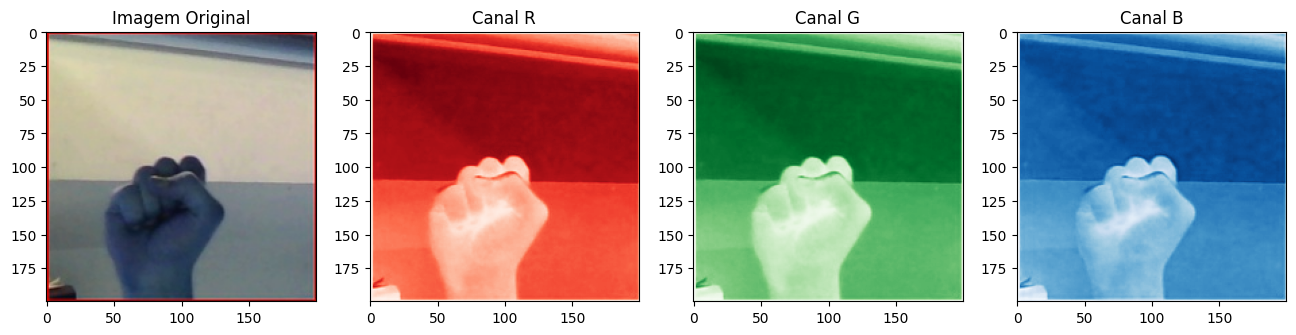

In [ ]:
matriz_imagem = np.asarray(imagem)

plt.figure(figsize=(16,8))
plt.subplot(141)

plt.imshow(imagem)
plt.title("Imagem Original")
plt.subplot(142)

plt.imshow(matriz_imagem[:, :, 1], cmap="Reds")
plt.title("Canal R")
plt.subplot(143)

plt.imshow(matriz_imagem[:, :, 1], cmap="Greens")
plt.title("Canal G")
plt.subplot(144)

plt.imshow(matriz_imagem[:, :, 2], cmap="Blues")
plt.title("Canal B")
plt.show()

## Pré-processamento de Imagens

Começaremos por remover o fundo da imagem, para facilitar o processamento.

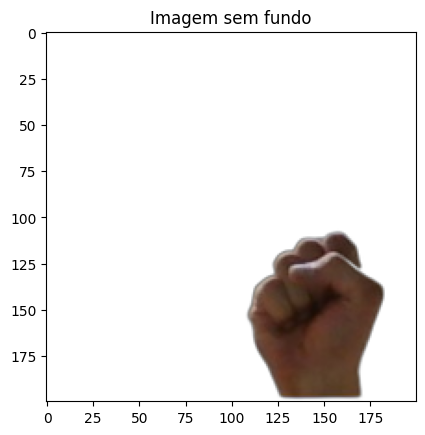

In [ ]:
img_sem_fundo = remove(image_rgb)

plt.imshow(img_sem_fundo)
plt.title('Imagem sem fundo')
plt.show()

Como os gestos não são dependentes de cores para serem reconhecidos, mas sim dos formatos, vamos converter a imagem para preto e branco.  
Trabalhar com imagens na escala cinza também reduz o custo computacional para realizar processos nas imagems.

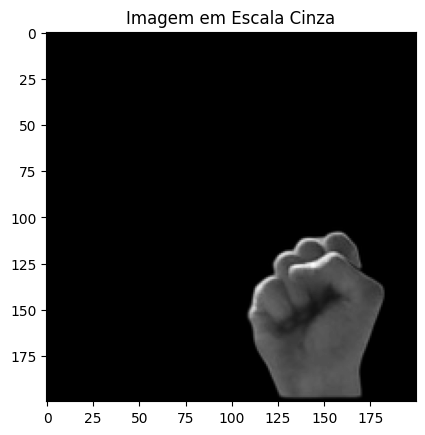

In [ ]:
imagem_cinza = cv2.cvtColor(img_sem_fundo, cv2.COLOR_RGB2GRAY)  # Conversão para escala cinza.
plt.imshow(imagem_cinza, cmap="gray")
plt.title("Imagem em Escala Cinza")
plt.show()

Uma vez na escala de cinza, a fim de ajustar o contraste e facilitar a identificaçao das principais características da imagem, aplica-se técnicas de realce.

<ipython-input-81-e0c1a7200606>:12: RuntimeWarning: divide by zero encountered in power
  img_gamma = (np.power(imagem_cinza/255, gamma)*255).astype(np.uint8)


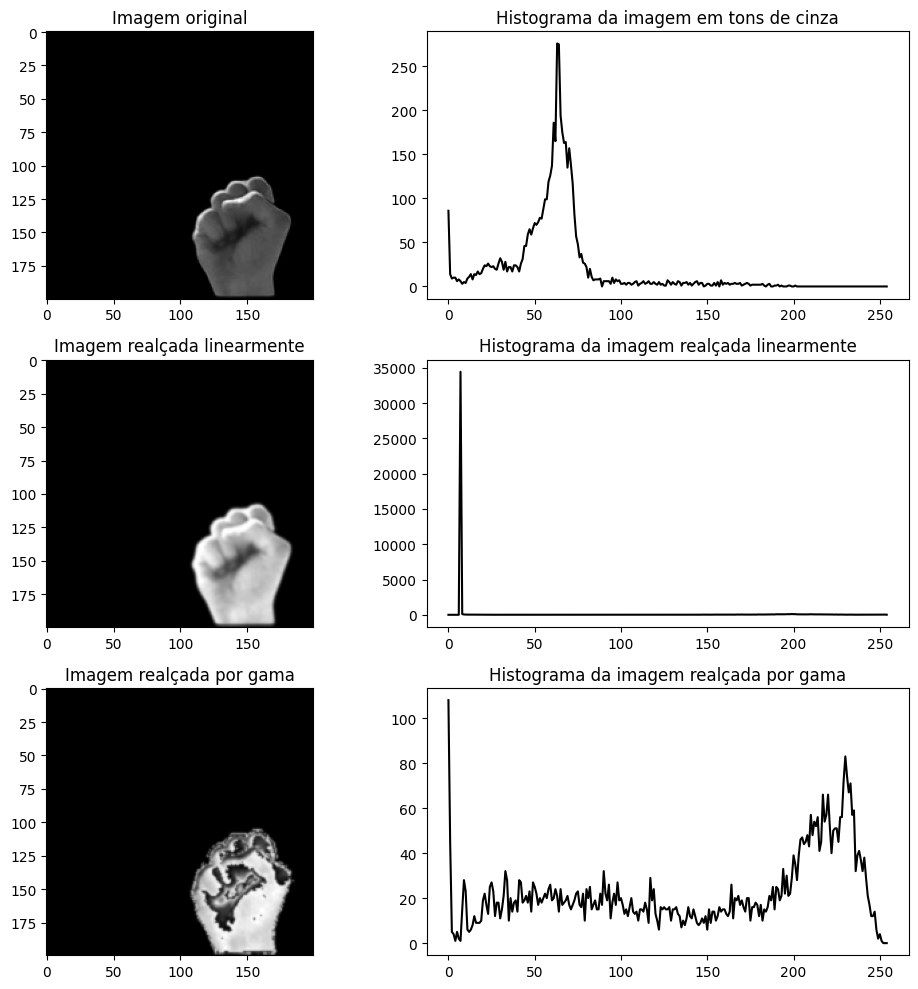

In [ ]:
from statistics import geometric_mean
from math import log10

#realce por filtro linear
alpha = 40/(1.7*imagem_cinza.mean())
img_equal = cv2.convertScaleAbs(imagem_cinza, alpha = alpha, beta = 8)
img_equal = cv2.GaussianBlur(img_equal, (5,5), 0.9, 0.9)

#realce por correção gama:
vetor = [i+1 for i in np.reshape(imagem_cinza, -1)] #conversao de imagem cinza para uma dimensao
gamma = log10(200/255)/log10(geometric_mean(vetor)) #calculo do melhor gama
img_gamma = (np.power(imagem_cinza/255, gamma)*255).astype(np.uint8)
img_gamma = cv2.GaussianBlur(img_gamma, (5,5), 0.7, 0.7)

#obtenção dos histogramas:
hist_cinza = cv2.calcHist([imagem_cinza],[0],None,[255],[1,256])
hist_equal = cv2.calcHist([img_equal],[0],None,[255],[1,256])
hist_gamma = cv2.calcHist([img_gamma],[0], None, [255], [1, 256])

#impressão das imagens
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.imshow(imagem_cinza, cmap='gray')
plt.title("Imagem original")

plt.subplot(3,2,2)
plt.plot(hist_cinza, color='black')
plt.title('Histograma da imagem em tons de cinza')

plt.subplot(3,2,3)
plt.imshow(img_equal, cmap='gray')
plt.title("Imagem realçada linearmente")

plt.subplot(3,2,4)
plt.plot(hist_equal, color='black')
plt.title('Histograma da imagem realçada linearmente')

plt.subplot(3,2,5)
plt.imshow(img_gamma, cmap='gray')
plt.title('Imagem realçada por gama')

plt.subplot(3,2,6)
plt.plot(hist_gamma, color='black')
plt.title('Histograma da imagem realçada por gama')

plt.tight_layout()
plt.show()

In [ ]:
img_log = cv2.intensity_transform.logTransform(imagem_cinza)
img_log = cv2.GaussianBlur(img_log, (5,5), 0.9, 0.9)

hist_log = cv2.calcHist([imagem_cinza],[0],None,[255],[1,256])

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(img_log, cmap='gray')
plt.title("Imagem original")

plt.subplot(1,2,2)
plt.plot(hist_log, color='black')
plt.title('Histograma da imagem em tons de cinza')

TypeError: ignored

'\nPercebe-se que Canny apresentou um desempenho melhor que Sobel.\n\nAlém disso, para aplicação de Canny, não precisa realizar o realce da imagem. O próprio algoritmo de Canny\nrealiza o calculo dos gradientes aplicando sobel para encontrar as bordas e também aplica um um filtro gaussiano\npara redução de ruído.\n'

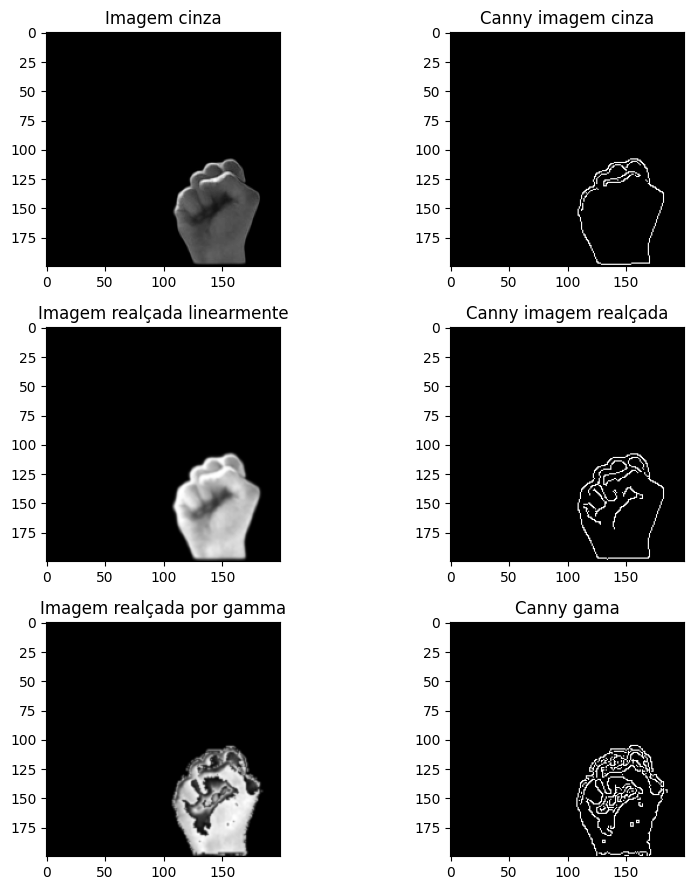

In [ ]:
img_canny1 = cv2.Canny(imagem_cinza, threshold1=90,threshold2=200)
img_canny2 = cv2.Canny(img_equal, threshold1=90,threshold2=200)
img_canny3 = cv2.Canny(img_gamma, threshold1=90, threshold2=200)

plt.figure(figsize=(9,9))

plt.subplot(3,2,1)
plt.imshow(imagem_cinza, cmap='gray')
plt.title('Imagem cinza')
plt.subplot(3,2,2)
plt.imshow(img_canny1, cmap='gray')
plt.title('Canny imagem cinza')
plt.subplot(3,2,3)
plt.imshow(img_equal, cmap='gray')
plt.title('Imagem realçada linearmente')
plt.subplot(3,2,4)
plt.imshow(img_canny2, cmap='gray')
plt.title('Canny imagem realçada')
plt.subplot(3,2,5)
plt.imshow(img_gamma, cmap='gray')
plt.title('Imagem realçada por gamma')
plt.subplot(3,2,6)
plt.imshow(img_canny3, cmap='gray')
plt.title('Canny gama')

plt.tight_layout()

"""
Percebe-se que Canny apresentou um desempenho melhor que Sobel.

Além disso, para aplicação de Canny, não precisa realizar o realce da imagem. O próprio algoritmo de Canny
realiza o calculo dos gradientes aplicando sobel para encontrar as bordas e também aplica um um filtro gaussiano
para redução de ruído.
"""

Para processamento da imagem pela rede neural, é importante a normalizaçao de seus pixels.

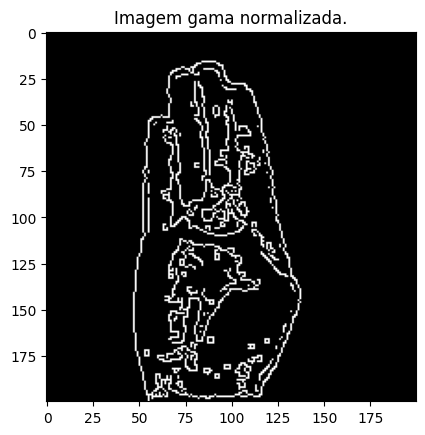

In [ ]:
def norma(img):
  return img/255 # normalização dos pixels da imagem

img_norm = norma(img_canny3)

plt.imshow(img_norm, cmap='gray')
plt.title("Imagem gama normalizada.")
plt.show()

##Importação dos dados

- O método window pode ser uma forma de pegar frações do dataset;
-

In [ ]:
#função de preprocessamento das imagens

def preprocessing (img):
  #remocao do fundo
  img_no_back = remove (img)

  #conversao para escala de cinza
  img_gray = cv2.cvtColor(img_no_back, cv2.COLOR_RGB2GRAY)

  #aplicaçao de filtro linear de realce e filtro gaussiano de suavização
  alpha = 40/(1.7*img_gray.mean())
  img_equal = cv2.convertScaleAbs(img_gray, alpha = alpha, beta = 8)
  img_equal = cv2.GaussianBlur(img_equal, (5,5), 0.9, 0.9)

  #deteccao das bordas
  img_canny = cv2.Canny(img_equal, threshold1=90,threshold2=200)

  #normalização das imagens
  img_canny = img_canny/255

  return img_canny

In [ ]:
directory_train = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
directory_test = 'asl-alphabet/asl_alphabet_test/'

train_dataset = keras.utils.image_dataset_from_directory(
    directory_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(200, 200),
    shuffle=True,
    seed=42,
    validation_split=0.25,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

val_dataset = keras.utils.image_dataset_from_directory(
    directory_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=None,
    image_size=(200, 200),
    shuffle=True,
    seed=42,
    validation_split=0.25,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

labels_test = train_dataset.class_names.remove('del') #nao tem del na base de teste

test_dataset = keras.utils.image_dataset_from_directory(
    directory_test,
    labels=list(range(0,28)), #as classes estão numeradas pela ordem alfanumérica
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=None,
    image_size=(200, 200),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 87000 files belonging to 29 classes.
Using 65250 files for training.
Found 87000 files belonging to 29 classes.
Using 21750 files for validation.
Found 28 files belonging to 28 classes.


In [ ]:
#aplicaçao da função de preprocessamento às imagens

train_dataset = train_dataset.apply(preprocessing)
val_dataset = val_dataset.apply(preprocessing)
test_dataset = test_dataset.apply(preprocessing)

ValueError: ignored

In [ ]:
#configuração de pipeline

AUTOTUNE = data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

##Arquivo

Células arquivadas.

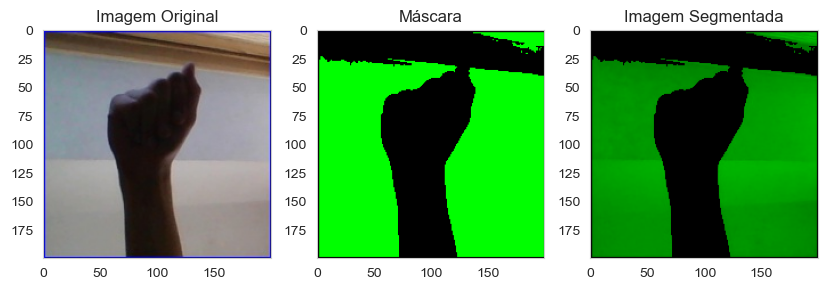

In [ ]:
gray_image = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(imagem)
cv2.drawContours(mask, contours, -1, (0, 255, 0), -1)
segmented_image = cv2.bitwise_and(imagem, mask)

plt.figure(figsize=(10, 5))
plt.subplot(131), plt.imshow(imagem[:, :, ::-1]), plt.title('Imagem Original')
plt.subplot(132), plt.imshow(mask[:, :, ::-1]), plt.title('Máscara')
plt.subplot(133), plt.imshow(segmented_image[:, :, ::-1]), plt.title('Imagem Segmentada')
plt.show()

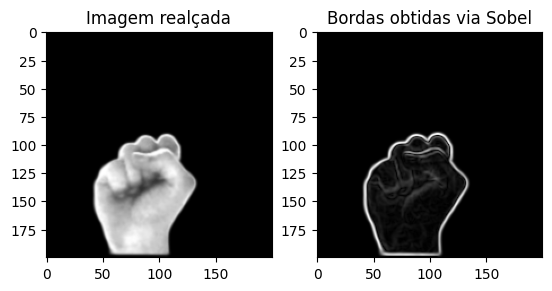

In [ ]:
sobel_x = cv2.Sobel(img_equal, cv2.CV_64F, 1, 0, ksize=3, scale = 1, delta = 0)
sobel_y = cv2.Sobel(img_equal, cv2.CV_64F, 0, 1, ksize=3, scale = 1, delta = 0)

gradient_mag = np.sqrt(sobel_x**2 + sobel_y**2)

plt.subplot(1,2,1)
plt.imshow(img_equal, cmap='gray')
plt.title('Imagem realçada')
plt.subplot(1,2,2)
plt.imshow(gradient_mag, cmap='gray')
plt.title('Bordas obtidas via Sobel')

plt.show()